<a href="https://colab.research.google.com/github/shanikairoshi/QFL_Experiments/blob/main/QFL_reviewCopy_of_Qiskit_QFL_with_qnn_BreastCancer_my_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture

!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

In [2]:
%%capture
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit-aer

<>:55: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
/tmp/ipython-input-3396852358.py:55: SyntaxWarning: "is" with 'int' literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


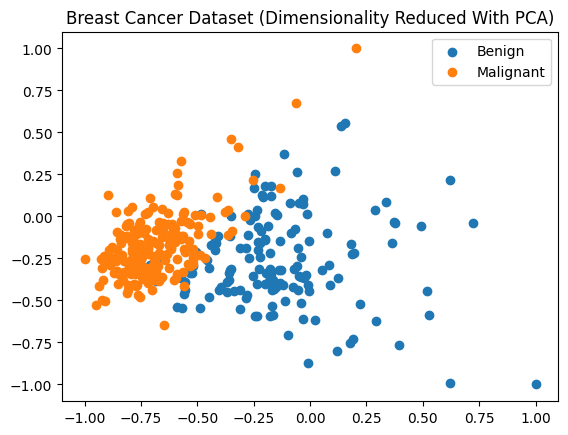

Training data shape: (349, 2)
Testing data shape: (49, 2)


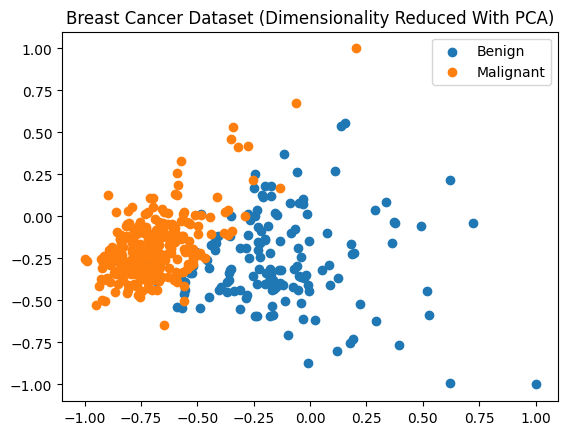

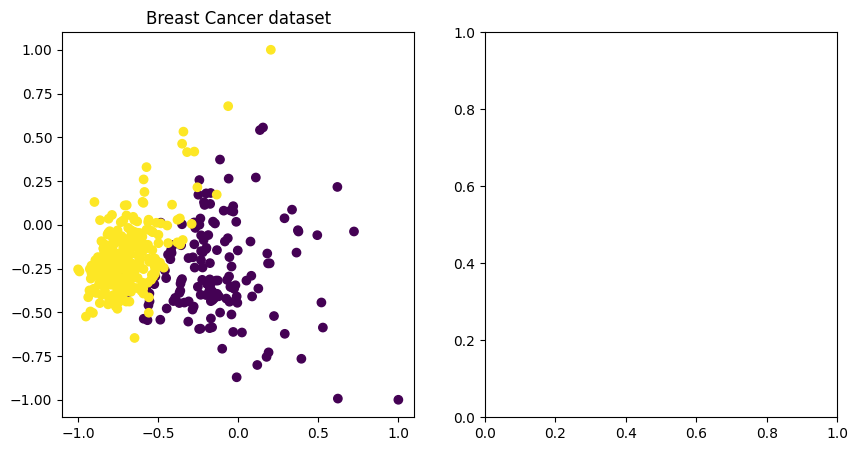

In [16]:

import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Define the number of clients
num_clients = 2
# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")

n = 2 # number of principal components kept
training_dataset_size = 500
testing_dataset_size = 125

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');


In [17]:
def split_data_among_clients(data_train, train_labels, data_test, test_labels, num_clients):
    # Ensure that training data and labels are split equally
    train_data_per_client = np.array_split(data_train, num_clients)
    train_labels_per_client = np.array_split(train_labels, num_clients)

    # Ensure that test data and labels are split equally
    test_data_per_client = np.array_split(data_test, num_clients)
    test_labels_per_client = np.array_split(test_labels, num_clients)

    clients = []

    for i in range(num_clients):
        # Ensure that training data and labels have the same number of samples
        client = {
            "train_data": train_data_per_client[i],
            "train_labels": train_labels_per_client[i],
            "test_data": test_data_per_client[i],
            "test_labels": test_labels_per_client[i]
        }
        clients.append(client)

    return clients


# Assume these are the sizes for the train and test data
# Adjust according to the real size of your data
data_train = np.random.rand(400, 2)  # Example train data
train_labels = np.random.randint(0, 2, 400)  # Example train labels
data_test = np.random.rand(50, 2)  # Example test data
test_labels = np.random.randint(0, 2, 50)  # Example test labels

# Split the dataset among clients
clients = split_data_among_clients(data_train, train_labels, data_test, test_labels, num_clients)

# Verifying the split
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    print(f"Training data shape: {client['train_data'].shape}")
    print(f"Training labels shape: {client['train_labels'].shape}")
    print(f"Test data shape: {client['test_data'].shape}")
    print(f"Test labels shape: {client['test_labels'].shape}\n")


Client 1:
Training data shape: (200, 2)
Training labels shape: (200,)
Test data shape: (25, 2)
Test labels shape: (25,)

Client 2:
Training data shape: (200, 2)
Training labels shape: (200,)
Test data shape: (25, 2)
Test labels shape: (25,)



In [18]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer




In [19]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Callback function to visualize training progress
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [23]:
import numpy as np
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

# Assume data_train, train_labels, data_test, test_labels are already defined
# For example, from your previous breast cancer dataset processing code
# data_train, train_labels, data_test, test_labels

num_epochs = 50
samples_per_epoch = 100
backend = Aer.get_backend('aer_simulator')

class Client:
    def __init__(self, data, labels, test_data, test_labels):  # Add test_data and test_labels to __init__
        self.data = data
        self.labels = labels  # Store labels
        self.test_data = test_data  # Store test_data as an attribute
        self.test_labels = test_labels  # Store test_labels as an attribute
        self.models = []
        self.train_scores = []
        self.test_scores = []
        self.primary_model = None

def split_dataset(data_train, train_labels, data_test, test_labels, num_clients, num_epochs, samples_per_epoch):
    clients = []
    # Split training data and labels among clients
    train_data_per_client = np.array_split(data_train, num_clients)
    train_labels_per_client = np.array_split(train_labels, num_clients)

    # Split test data and labels among clients
    test_data_per_client = np.array_split(data_test, num_clients)
    test_labels_per_client = np.array_split(test_labels, num_clients)

    for i in range(num_clients):
        client_data = []
        client_labels = []
        for j in range(num_epochs):
            # Use part of the data for each epoch (depending on samples_per_epoch)
            start_idx = (j * samples_per_epoch)
            end_idx = ((j + 1) * samples_per_epoch)

            # Append data and labels for each epoch
            client_data.append(train_data_per_client[i][start_idx:end_idx])
            client_labels.append(train_labels_per_client[i][start_idx:end_idx])

        # Concatenate data across epochs for the client
        client_data = np.vstack(client_data)
        client_labels = np.hstack(client_labels)

        # Create Client instance with both train and test data
        clients.append(Client(client_data, client_labels, test_data_per_client[i], test_labels_per_client[i]))

    return clients

# Use data_train, train_labels, data_test, and test_labels in split_dataset function
clients = split_dataset(data_train, train_labels, data_test, test_labels, num_clients, num_epochs, samples_per_epoch)

# Verifying the split
for idx, client in enumerate(clients):
    print(f"Client {idx + 1}:")
    print(f"Training data shape: {client.data.shape}")
    print(f"Training labels shape: {client.labels.shape}")
    print(f"Test data shape: {client.test_data.shape}")
    print(f"Test labels shape: {client.test_labels.shape}\n")


Client 1:
Training data shape: (200, 2)
Training labels shape: (200,)
Test data shape: (25, 2)
Test labels shape: (25,)

Client 2:
Training data shape: (200, 2)
Training labels shape: (200,)
Test data shape: (25, 2)
Test labels shape: (25,)



In [24]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data  # Features
y = data.target  # Labels (0 for malignant, 1 for benign)

# Normalize the dataset (if needed)
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Apply PCA to reduce the number of dimensions (e.g., to 5 components)
num_components = 5  # Set the number of dimensions you want to reduce to
pca = PCA(n_components=num_components)
X_reduced = pca.fit_transform(X)  # Reduce the dimensionality of the data

# Split the reduced dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Assume num_clients is the number of clients you want to simulate
num_clients = 5
client_data_size = len(X_train) // num_clients

clients = []

for i in range(num_clients):
    client_data = {
        "sequence": X_train[i * client_data_size:(i + 1) * client_data_size],
        "label": y_train[i * client_data_size:(i + 1) * client_data_size]
    }
    client_test_data = {
        "sequence": X_test,
        "label": y_test
    }
    clients.append({
        "data": client_data,
        "test_data": client_test_data,
        "primary_model": None,
        "models": [],
        "train_scores": [],
        "test_scores": []
    })

# Now each client has reduced dimensionality data (5 dimensions) for both training and testing


In [25]:
# Function to initialize a new QNN model (same architecture as clients' models)
def initialize_model(num_features):
    # Create the same quantum neural network (QNN) architecture as clients
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

    # Combine the feature map and ansatz into a single quantum circuit
    qc = feature_map.compose(ansatz)

    # Use parity as the interpretation function
    def parity(x):
        return "{:b}".format(x).count("1") % 2  # Binary classification

    # Explicitly define input_params and weight_params
    input_params = feature_map.parameters  # Input parameters (for encoding)
    weight_params = ansatz.parameters      # Trainable parameters (for optimization)

    # Define the QNN model using a sampler
    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,  # Binary classification
        input_params=input_params,
        weight_params=weight_params
    )

    # Create a classifier using the neural network
    qnn_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=SPSA(maxiter=50)  # Use SPSA optimizer
    )

    return qnn_classifier

# Function to create a model with averaged weights
def create_model_with_weights(average_weights, num_features):
    # Initialize a new QNN model with the same architecture
    model = initialize_model(num_features)
    # Assign the averaged weights to the model's trainable parameters (ansatz weights)
    weight_params = model.neural_network.weight_params  # Get the trainable parameters

    # Check if the lengths match, and truncate if necessary
    num_weights = min(len(average_weights), len(weight_params))

    # Create a dictionary mapping parameters to averaged weights
    param_dict = {param: average_weights[i] for i, param in enumerate(weight_params[:num_weights])}


    # Assign the averaged weights to the circuit parameters
    model.neural_network.circuit.assign_parameters(param_dict)

    return model


In [26]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Callback function to visualize training progress
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Function to create the QNN model
def create_qnn_model(num_features):
    # num_features = data_train[0]["sequence"].shape[0]  # Remove this line as data_train is not defined
    # Define the quantum feature map and ansatz
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)  # Use num_features passed as argument
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

    # Construct the quantum neural network using a sampler
    qc = feature_map.compose(ansatz)  # Build the QNN circuit
    print(f"Number of features (input dimension): {num_features}")
    print(f"Number of circuit parameters: {qc.num_parameters}")

    # Use parity as the interpretation function
    def parity(x):
        return "{:b}".format(x).count("1") % 2  # Binary classification

    # Explicitly define input_params and weight_params
    input_params = feature_map.parameters  # Parameters for the feature map (inputs)
    weight_params = ansatz.parameters      # Parameters for the ansatz (weights)
    #print(f"Input Parameters: {input_params}")
    #print(f"Weight Parameters: {weight_params}")

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,  # Output dimension for binary classification
        input_params=input_params,       # Pass input parameters
        weight_params=weight_params     # Pass weight parameters
    )

    # Define a classifier using the QNN
    qnn_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=SPSA(maxiter=50),  # Example with SPSA optimizer
        #callback=callback_graph
    )

    return qnn_classifier

In [27]:
def getAccuracy(weights, num_features, test_sequences, test_labels):
    # Rebuild the QNN model with the given weights
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

    # Replace bind_parameters with assign_parameters
    # Create a parameter dictionary for assignment
    param_dict = {param: weight for param, weight in zip(ansatz.parameters, weights)}
    ansatz = ansatz.assign_parameters(param_dict)

    # Rebuild the QNN using the updated ansatz
    qc = feature_map.compose(ansatz)

    # Define the parity function for binary classification
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    # Build the SamplerQNN with the updated circuit
    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,  # Binary classification
        input_params=feature_map.parameters,  # Input parameters (from the feature map)
        weight_params=ansatz.parameters  # Weight parameters (from the ansatz)
    )

    # Build the NeuralNetworkClassifier with the QNN
    qnn_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=COBYLA(maxiter=0)  # No need for further optimization
    )

    # Train the classifier on a subset of test data (or use full test data if preferred)
    qnn_classifier.fit(test_sequences, test_labels)

    # Return the accuracy on a larger test set
    return qnn_classifier.score(test_sequences, test_labels)


In [28]:
import os
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = '/content/drive/MyDrive/QFL_folder/federated_qnn_metrics.csv'  # change if you like
os.makedirs(os.path.dirname(CSV_PATH), exist_ok=True)

import csv
import numpy as np

def init_metrics_csv(csv_path: str, num_clients: int):
    """Create/overwrite CSV with a header."""
    header = ['Epoch', 'GlobalAccuracy']
    for i in range(num_clients):
        header += [f'Client{i}_TrainAcc', f'Client{i}_TestAcc']
    with open(csv_path, 'w', newline='') as f:
        csv.writer(f).writerow(header)

def append_metrics_row(csv_path: str, epoch: int, global_acc: float,
                       train_accs: list[float], test_accs: list[float]):
    """Append one epoch’s metrics."""
    row = [epoch, global_acc] + [
        x for pair in zip(train_accs, test_accs) for x in pair
    ]
    with open(csv_path, 'a', newline='') as f:
        csv.writer(f).writerow(row)

def compute_global_accuracy(model, clients: list[dict]) -> float:
    """Evaluate the current global model on the union of all client test sets."""
    X = np.concatenate([c["test_data"]["sequence"] for c in clients], axis=0)
    y = np.concatenate([c["test_data"]["label"]   for c in clients],   axis=0)
    return float(model.score(X, y))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import time
import csv
import numpy as np

# Lists to store accuracies over epochs
global_model_weights = {}
global_model_accuracy = []
clients_train_accuracies = []  # List to store train accuracies per epoch per client
clients_test_accuracies = []   # List to store test accuracies per epoch per client

# Function to train the QNN model for one client
def train_qnn_model(client_data, client_test_data, model=None):
    if model is None:
        # Create a new QNN model if one doesn't exist
        #model = create_qnn_model(client_data["sequence"].shape[1])  # Number of features
        num_features = client_data["sequence"].shape[1]
        model = create_qnn_model(num_features)  # Pass num_features

    # Extract sequences and labels for training
    train_sequences = client_data["sequence"]
    train_labels = client_data["label"]

    # Extract sequences and labels for testing
    test_sequences = client_test_data["sequence"]
    test_labels = client_test_data["label"]

    print("Training started...")
    start_time = time.time()

    # Train the QNN model
    model.fit(train_sequences, train_labels)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time} seconds.")

    # Evaluate the model on training and test data
    train_score_q = model.score(train_sequences, train_labels)
    test_score_q = model.score(test_sequences, test_labels)

    return model, train_score_q, test_score_q, elapsed_time

# Function to manually average the numerical values of the parameters across clients
def manual_average_weights(epoch_weights):
    # Initialize a list to store the summed weights (initialize with zeros)
    num_weights = len(epoch_weights[0])  # Number of weights in the model
    num_clients = len(epoch_weights)  # Number of clients

    # Initialize sum of weights to zero (assuming NumPy array or list of weights)
    summed_weights = np.zeros(num_weights)

    # Sum the weights from all clients
    for client_weights in epoch_weights:
        summed_weights += np.array(client_weights)

    # Compute the average by dividing the summed weights by the number of clients
    average_weights = summed_weights / num_clients

    return average_weights

# Function to save accuracies to CSV
def save_accuracies_to_csv(global_accuracies, clients_train_accuracies, clients_test_accuracies, filename='accuracies.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header row
        header = ['Epoch', 'Global Accuracy']
        for i in range(len(clients_train_accuracies[0])):  # Assuming all clients have the same number of records
            header.append(f'Client {i} Train Accuracy')
            header.append(f'Client {i} Test Accuracy')
        writer.writerow(header)

        # Write the accuracy data for each epoch
        for epoch in range(len(global_accuracies)):
            row = [epoch, global_accuracies[epoch]]  # Start with epoch and global accuracy
            for client_index in range(len(clients_train_accuracies[epoch])):
                row.append(clients_train_accuracies[epoch][client_index])  # Add train accuracy for client
                row.append(clients_test_accuracies[epoch][client_index])   # Add test accuracy for client
            writer.writerow(row)

import numpy as np

def _logits_to_labels(y_raw: np.ndarray) -> np.ndarray:
    """Robust conversion from network outputs to class labels."""
    y_raw = np.asarray(y_raw)
    if y_raw.ndim == 1:
        # Binary, single logit (e.g., expectation). Threshold at 0.
        return (y_raw >= 0).astype(int)
    elif y_raw.ndim == 2:
        if y_raw.shape[1] == 1:
            return (y_raw[:, 0] >= 0).astype(int)
        # Multi-class or 2-class with 2 outputs
        return np.argmax(y_raw, axis=1)
    else:
        raise ValueError("Unexpected network output shape: {}".format(y_raw.shape))


def compute_global_accuracy_from_weights(prototype_model, avg_weights: np.ndarray, clients: list) -> float:
    """
    Use a *fitted* prototype_model to access its underlying QNN and
    forward the averaged parameter vector 'avg_weights' over the
    concatenated global test set, returning accuracy.
    """
    # 1) Build the global test pool
    Xg = np.concatenate([c["test_data"]["sequence"] for c in clients], axis=0)
    yg = np.concatenate([c["test_data"]["label"]   for c in clients], axis=0)

    # 2) Extract the underlying QNN (works for NeuralNetworkClassifier built on {Sampler,Estimator}QNN)
    qnn = getattr(prototype_model, "neural_network", None)
    if qnn is None:
        # Some versions use a protected attribute
        qnn = getattr(prototype_model, "_neural_network", None)
    if qnn is None:
        raise RuntimeError("Cannot access underlying QNN from the classifier.")

    # 3) Forward pass with the *averaged* parameter vector (no fit needed)
    y_raw = qnn.forward(Xg, np.asarray(avg_weights))

    # 4) Convert to labels and compute accuracy
    y_pred = _logits_to_labels(y_raw)
    return float(np.mean(y_pred == yg))


# Federated learning loop
num_features = 5
num_epochs = 20
global_model_weights = {}

num_clients = len(clients)
init_metrics_csv(CSV_PATH, num_clients)
global_model_accuracy = []
# Initialize 'primary_model' for each client
for client in clients:  # Assuming 'clients' is your list of client dictionaries
    client["primary_model"] = None  # Initialize 'primary_model' to None

for epoch in range(num_epochs):
    global_model_weights[epoch] = []
    epoch_weights = []

    epoch_train_accuracies = []  # Store train accuracies for this epoch
    epoch_test_accuracies = []   # Store test accuracies for this epoch
    print(f"Epoch: {epoch}")

    # Train each client
    for index, client in enumerate(clients):
        print(f"Training Client {index}")
        # Use dictionary key access instead of dot notation
        if client["primary_model"] is None:
            # Pass both training and test data to the training function
            model, train_score_q, test_score_q, train_time = train_qnn_model(client["data"], client["test_data"])
            client["primary_model"] = model
        else:
            model, train_score_q, test_score_q, train_time = train_qnn_model(client["data"], client["test_data"], model=client["primary_model"])

        client["models"].append(model)
        client["train_scores"].append(train_score_q)
        client["test_scores"].append(test_score_q)

        print(f"Client {index} Train Score: {train_score_q}")
        print(f"Client {index} Test Score: {test_score_q}")
        print("\n\n")
        print("----------------------------------------------------------")

        # Append client accuracies for this epoch
        epoch_train_accuracies.append(train_score_q)
        epoch_test_accuracies.append(test_score_q)

        # Collect model weights (assuming model has a "weights" attribute that can be averaged)
        epoch_weights.append(model.weights)

   # Manually compute the average weights
    average_weights = manual_average_weights(epoch_weights)

    # Update the global model weights
    print("Global model updated")
    global_model_weights[epoch] = average_weights

    # --- remove these lines ---
# new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch], num_features)
# for index, client in enumerate(clients):
#     client["primary_model"] = new_model_with_global_weights
# global_acc = compute_global_accuracy(new_model_with_global_weights, clients)
# --------------------------------

    # --- insert this instead ---
    avg_w = global_model_weights[epoch]
    # Use any client model that was trained this epoch as a *fitted prototype*:
    prototype = clients[0]["primary_model"]
    global_acc = compute_global_accuracy_from_weights(prototype, avg_w, clients)
    global_model_accuracy.append(global_acc)

    # set starting point for the NEXT epoch’s training
    for c in clients:
        c["next_init"] = avg_w.copy()
        c["primary_model"].initial_point = np.asarray(avg_w)


    # # Calculate global accuracy using the test data
    # test_sequences = clients[0]["test_data"]["sequence"]  # Access test_sequences
    # test_labels = clients[0]["test_data"]["label"]  # Access test_labels
    # global_accuracy = getAccuracy(global_model_weights[epoch], num_features, test_sequences, test_labels)
    # global_model_accuracy.append(global_accuracy)

    # Save the clients' train/test accuracies for this epoch
    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    # compute global accuracy on the combined test set
    #global_acc = compute_global_accuracy(new_model_with_global_weights, clients)
    #global_model_accuracy.append(global_acc)

    # APPEND one row to Drive for this epoch
    append_metrics_row(
        CSV_PATH,
        epoch,
        global_acc,
        epoch_train_accuracies,
        epoch_test_accuracies
    )

    # print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")
    print(f"[Epoch {epoch}] global_acc={global_acc:.4f} "
          f"| train={epoch_train_accuracies} | test={epoch_test_accuracies}")




Epoch: 0
Training Client 0
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


/tmp/ipython-input-3714545703.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 114.6827130317688 seconds.
Client 0 Train Score: 0.7802197802197802
Client 0 Test Score: 0.47368421052631576



----------------------------------------------------------
Training Client 1
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


/tmp/ipython-input-3714545703.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 114.8433575630188 seconds.
Client 1 Train Score: 0.6593406593406593
Client 1 Test Score: 0.5263157894736842



----------------------------------------------------------
Training Client 2
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


/tmp/ipython-input-3714545703.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 115.1090738773346 seconds.
Client 2 Train Score: 0.7142857142857143
Client 2 Test Score: 0.5350877192982456



----------------------------------------------------------
Training Client 3
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


/tmp/ipython-input-3714545703.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 115.62103962898254 seconds.
Client 3 Train Score: 0.6813186813186813
Client 3 Test Score: 0.4824561403508772



----------------------------------------------------------
Training Client 4
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


/tmp/ipython-input-3714545703.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 114.96731281280518 seconds.
Client 4 Train Score: 0.7032967032967034
Client 4 Test Score: 0.43859649122807015



----------------------------------------------------------
Global model updated
----------------------------------------------------------
[Epoch 0] global_acc=0.5088 | train=[0.7802197802197802, 0.6593406593406593, 0.7142857142857143, 0.6813186813186813, 0.7032967032967034] | test=[0.47368421052631576, 0.5263157894736842, 0.5350877192982456, 0.4824561403508772, 0.43859649122807015]
Epoch: 1
Training Client 0
Training started...
Training completed in 116.80927467346191 seconds.
Client 0 Train Score: 0.7252747252747253
Client 0 Test Score: 0.4824561403508772



----------------------------------------------------------
Training Client 1
Training started...
Training completed in 114.6497209072113 seconds.
Client 1 Train Score: 0.6483516483516484
Client 1 Test Score: 0.5789473684210527



----------------------------------------------------------
Training 

Visualizing Results

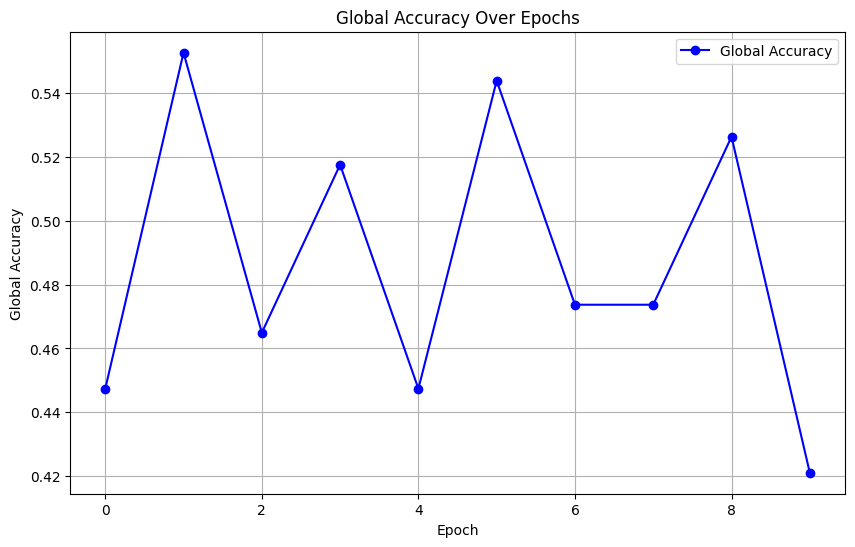

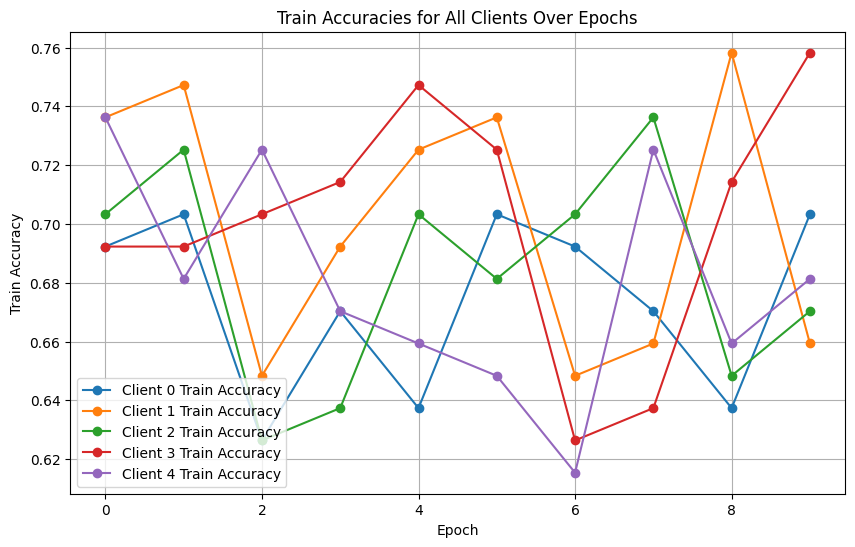

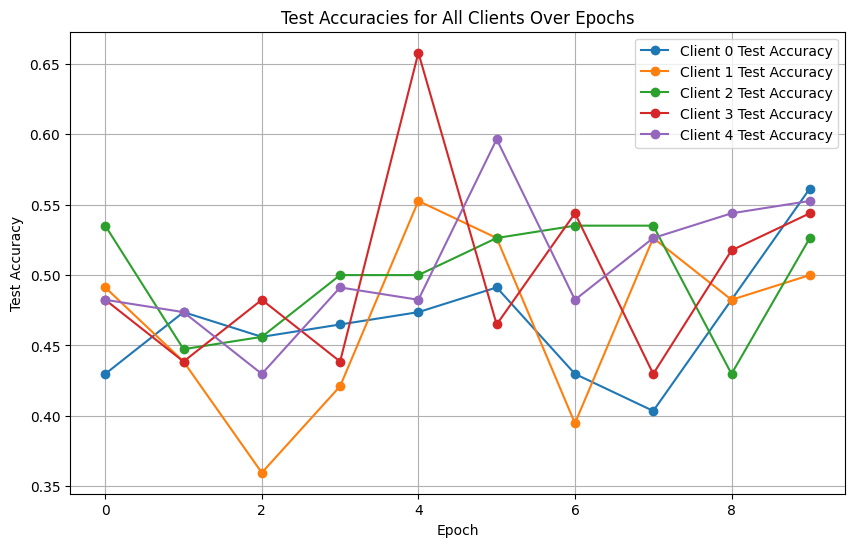

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
filename = 'accuracies.csv'
data = pd.read_csv(filename)

# Extract the relevant columns for plotting
epochs = data['Epoch']
global_accuracy = data['Global Accuracy']
client_train_accuracies = data.filter(like='Train Accuracy').values
client_test_accuracies = data.filter(like='Test Accuracy').values

# Plot Global Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, global_accuracy, label='Global Accuracy', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global Accuracy')
plt.title('Global Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Train Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_train_accuracies.shape[1]):
    plt.plot(epochs, client_train_accuracies[:, i], label=f'Client {i} Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracies for All Clients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Test Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_test_accuracies.shape[1]):
    plt.plot(epochs, client_test_accuracies[:, i], label=f'Client {i} Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies for All Clients Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


new ways to average

In [ ]:
global_model_weights = {}
global_model_accuracy = []

# Federated learning loop
for epoch in range(num_epochs):
    global_model_weights[epoch] = []
    epoch_weights = []
    print(f"Epoch: {epoch}")

    # Train each client
    for index, client in enumerate(clients):
        print(f"Training Client {index}")

        if client.primary_model is None:
            # First time training: no existing model
            train_score_q, test_score_q, model = train(data=client.data[epoch])
            client.primary_model = model
        else:
            # Continue training with the existing model
            train_score_q, test_score_q, model = train(data=client.data[epoch], model=client.primary_model)

        # Save model and scores
        client.models.append(model)
        client.train_scores.append(train_score_q)
        client.test_scores.append(test_score_q)

        # Extract and collect model weights
        print(f"Train Score: {train_score_q}")
        print(f"Test Score: {test_score_q}")
        print("\n\n")

        # Assuming model.weights returns a NumPy array or list of weights
        epoch_weights.append(model.weights)

    # Average the weights across all clients
    average_weights = sum(epoch_weights) / len(epoch_weights)

    # Create a new model with the averaged global weights
    global_model_weights[epoch] = average_weights
    new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch])

    # Update each client's primary model with the global averaged weights
    for index, client in enumerate(clients):
        client.primary_model = new_model_with_global_weights

    # Optionally calculate global accuracy (if applicable in your case)
    global_accuracy = getAccuracy(global_model_weights[epoch])  # Assuming getAccuracy() works with global weights
    global_model_accuracy.append(global_accuracy)

    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


In [ ]:
# Function to extract numerical values of parameters
def extract_param_values(model):
    param_values = []
    # Loop through each parameter in the circuit and get its bound value
    for param in model.neural_network.circuit.parameters:
        # Extract the numerical value (assuming they are already bound with values)
        bound_value = model.neural_network.circuit._parameters[param]
        param_values.append(bound_value)
    return np.array(param_values)

# Function to set numerical values of parameters back into the circuit
def set_param_values(model, param_values):
    # Assign the averaged parameter values back to the circuit
    parameter_dict = {param: value for param, value in zip(model.neural_network.circuit.parameters, param_values)}
    model.neural_network.circuit.assign_parameters(parameter_dict)

# Federated learning loop
for epoch in range(num_epochs):
    global_model_weights[epoch] = []
    epoch_weights = []
    print(f"Epoch: {epoch}")

    # Train each client
    for index, client in enumerate(clients):
        print(f"Training Client {index}")

        if client.primary_model is None:
            # Pass both training and test data to the training function
            model, train_score_q, test_score_q, train_time = train_qnn_model(client.data[epoch], client.test_data[epoch])
            client.primary_model = model
        else:
            model, train_score_q, test_score_q, train_time = train_qnn_model(client.data[epoch], client.test_data[epoch], model=client.primary_model)

        client.models.append(model)
        client.train_scores.append(train_score_q)
        client.test_scores.append(test_score_q)

        print(f"Client {index} Train Score: {train_score_q}")
        print(f"Client {index} Test Score: {test_score_q}")
        print("  ")
        print("----------------------------------------------------------")

        # Collect model weights (extract numerical parameter values)
        param_values = extract_param_values(client.primary_model)
        epoch_weights.append(param_values)

    # Average the numerical values of the parameters across clients
    average_weights = np.mean(epoch_weights, axis=0)

    # Manually update each client's model parameters with the averaged weights
    global_model_weights[epoch] = average_weights

    for client in clients:
        # Manually set the global averaged weights to the model's parameters
        set_param_values(client.primary_model, global_model_weights[epoch])

    # Calculate global accuracy
    global_accuracy = getAccuracy(global_model_weights[epoch])

    # Print global accuracy for the epoch
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


33333333333333333333333333333333333333333333

In [ ]:
global_model_weights = {}
global_model_accuracy = []

# Function to train the QNN model for one client
def train_qnn_model(client_data,client_test_data, model=None):
    #num_features = client_data[0]["sequence"].shape[0]  # Get the feature dimension
    # Debug: Print the client data structure
    print("Client Test Data Structure:", client_test_data)
    if model is None:
        # Create a new QNN model if one doesn't exist
        model = create_qnn_model(client_data)

    # Extract sequences and labels for training
    train_sequences = [data_point["sequence"] for data_point in client_data]
    train_labels = [data_point["label"] for data_point in client_data]

    # Extract sequences and labels for testing
    # Handle test data
    if isinstance(client_test_data, dict):
        # Single data point (dictionary format)
        test_sequences = np.array([client_test_data["sequence"]])
        test_labels = np.array([client_test_data["label"]])
    else:
        # List of dictionaries (multiple data points)
        test_sequences = [data_point["sequence"] for data_point in client_test_data]
        test_labels = [data_point["label"] for data_point in client_test_data]
        test_sequences = np.array(test_sequences)
        test_labels = np.array(test_labels)

    # Convert lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)


    print("Training started...")
    start_time = time.time()

    # Train the QNN model
    model.fit(train_sequences, train_labels)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time} seconds.")

    # Evaluate the model on training and test data
    train_score_q = model.score(train_sequences, train_labels)
    test_score_q = model.score(test_sequences, test_labels)

    return model, train_score_q, test_score_q, elapsed_time

# Federated learning loop
for epoch in range(num_epochs):
    global_model_weights[epoch] = []
    epoch_weights = []
    print(f"Epoch: {epoch}")

    # Train each client
    for index, client in enumerate(clients):
        print(f"Training Client {index}")

        if client.primary_model is None:
            # Pass both training and test data to the training function
            model, train_score_q, test_score_q, train_time = train_qnn_model(client.data[epoch], client.test_data[epoch])
            client.primary_model = model
        else:
            model, train_score_q, test_score_q, train_time = train_qnn_model(client.data[epoch], client.test_data[epoch], model=client.primary_model)

        client.models.append(model)
        client.train_scores.append(train_score_q)
        client.test_scores.append(test_score_q)

        print(f"Client {index} Train Score: {train_score_q}")
        print(f"Client {index} Test Score: {test_score_q}")
        print("  ")
        print("----------------------------------------------------------")

        for model in client.models:
        # Extract numerical values of parameters (as a NumPy array)
            param_values = [p.value for p in model.neural_network.circuit.parameters] # Extract the values
            epoch_weights.append(param_values)

    # Average the numerical values of the parameters across clients
    average_weights = np.mean(epoch_weights, axis=0)

    # Manually update each client's model parameters with the averaged weights
    global_model_weights[epoch] = average_weights

    for client in clients:
        # Manually set the global averaged weights to the model's parameters
        for i, param in enumerate(client.primary_model.neural_network.circuit.parameters):
            client.primary_model.neural_network.circuit._parameters[param] = average_weights[i] # Set the value directly


    # Calculate global accuracy
    global_accuracy = getAccuracy(global_model_weights[epoch])

    # Print global accuracy for the epoch
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


In [ ]:

import time

itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr}", end=' | ')
def train(data, model = None):
  if model is None:
    num_features = len(data[0]["sequence"])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=partial(training_callback),
        sampler=BackendSampler(backend=backend),
        warm_start=True
    )
    model = vqc_model

  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]

  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train Sequences Shape:", train_sequences.shape)
  print("Train Labels Shape:", train_labels.shape)

  print("Training Started")
  start_time = time.time()
  model.fit(train_sequences, train_labels)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_sequences, train_labels)
  test_score_q = model.score(test_sequences[:200], test_labels[:200])
  return train_score_q, test_score_q, model

def getAccuracy(weights):
        num_features = len(test_sequences[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        ansatz = ansatz.bind_parameters(weights)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=BackendSampler(backend=backend)
        )
        vqc.fit(test_sequences[:25], test_labels[:25])
        return vqc.score(test_sequences[:200], test_labels[:200])

def create_model_with_weights(weights):
  num_features = len(test_sequences[0])
  feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
  ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
  optimizer = COBYLA(maxiter=max_train_iterations)
  vqc = VQC(
      feature_map=feature_map,
      ansatz=ansatz,
      optimizer=optimizer,
      sampler=BackendSampler(backend=backend),
      warm_start = True,
      initial_point  = weights,
      callback=partial(training_callback)
  )
  return vqc


global_model_weights = {}
global_model_accuracy = []

for epoch in range(num_epochs):
  global_model_weights[epoch] = []
  epoch_weights = []
  print(f"epoch: {epoch}")
  for index, client in enumerate(clients):
    print(f"Index: {index}, Client: {client}")

    if client.primary_model is None:
      train_score_q, test_score_q, model = train(data = client.data[epoch])
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      # Print the values
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)

    else:
      train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
      client.models.append(model)
      client.test_scores.append(test_score_q)
      client.train_scores.append(train_score_q)
      print("Train Score:", train_score_q)
      print("Test Score:", test_score_q)
      print("\n\n")
      epoch_weights.append(model.weights)


if(epoch != 0):
    epoch_weights.append(global_model_weights[epoch-1])
average_weights = sum(epoch_weights) / len(epoch_weights)

global_model_weights[epoch] = average_weights
new_model_with_global_weights = create_model_with_weights(global_model_weights[epoch])
for index, client in enumerate(clients):
  client.primary_model = new_model_with_global_weights

global_accuracy = getAccuracy(global_model_weights[epoch])
print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
print("----------------------------------------------------------")
global_model_accuracy.append(global_accuracy)

